
<div style="font-size:2em; color:blue; font-weight:bold; text-align: center;">
Post-fire Restoration Tool for Chaparral Shrublands
    </div>

<ul style="font-size: 1.4em; color: blue;">
    
<li style="margin: 0 0 5px 0">The Post-Fire Restoration Tool provides a transparent and repeatable framework for resource managers to guide and prioritize post-fire restoration efforts in shrublands (see Technical Guide). The tool consists of five main steps (see schematic) to determine the regeneration capacity of the landscape post-fire based on the relative proportion of seeding, resprouting, and facultative seeding species, and the risk of post-fire soil erosion.</li>

<li style="margin: 0 0 5px 0">Before running the tool it is necessary to have the data associated with the tool in the directory labeled 'datasets' below the location of the .ipynb file for the tool (see Technical Guide). </li> 

<li style="margin: 0 0 5px 0">To view the tool with the programming code, click on the link on the line below the figure. </li>
</ul>



![Framework for Modeling Regeneration](images/Figure1.png)


<div style="font-size:2em; color:blue; font-weight:bold; text-align: center;">
Post-fire Restoration Tool for Chaparral Shrublands
    </div>

<ul style="font-size: 1.4em; color: blue;">
    
<li style="margin: 0 0 5px 0">The Post-Fire Restoration Tool provides a transparent and repeatable framework for resource managers to guide and prioritize post-fire restoration efforts in shrublands (see Technical Guide). The tool consists of five main steps (see schematic) to determine the regeneration capacity of the landscape post-fire based on the relative proportion of seeding, resprouting, and facultative seeding species, and the risk of post-fire soil erosion.</li>

<li style="margin: 0 0 5px 0">Before running the tool it is necessary to have the data associated with the tool in the directory labeled 'datasets' below the location of the .ipynb file for the tool (see Technical Guide). </li> 

<li style="margin: 0 0 5px 0">To view the tool with the programming code, click on the link on the line below the figure. </li>
</ul>

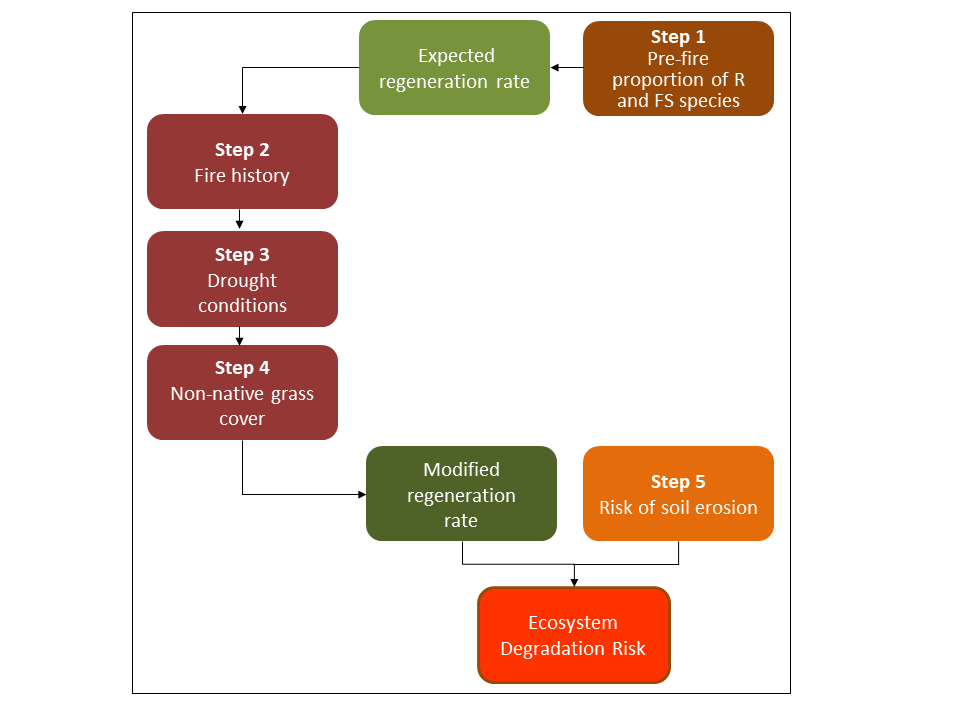

In [39]:
# see https://stackoverflow.com/questions/32714783/ipython-run-all-cells-below-from-a-widget
# for idea on how to get code executing above (not below) a widget.

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [40]:
# basic imports
import os
import pandas as pd
import numpy as np
import xarray as xr
import ipywidgets as widgets
import traitlets
from tkinter import Tk, filedialog
from IPython.display import Javascript

# more imports
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gdal
import rasterio


In [41]:
%%html
<style>
hr {height: 2px; color: black;}
p {font-size: 1.2em;}
h2 {color: black}
.highcol {background-color: #00BF57;}
.midcol {background-color: #FFC000;}
.lowcol {background-color: red;}
.vhighcol {background-color: #C00000; color: white}
.tsh {font-style: italic}
.tmh {font-weight: bold; text-align: center}

.infotext {color: blue; font-size: 1.3em}
td {font-size: 1.2em}           
.infobox {border-style: none;
          border-color: blue;
          border-width: 1px;
          font-style: normal;
          font-size: 1.2em;
          color: blue;}
td.fwdt {border: 2px;}
#nonnative table, #nonnative td { border: 1px solid black;}
#erosionvuln table, #erosionvuln td { border: 1px solid black;}
#regentab table, #regentab td { border: 1px solid black;}
#firefreq table, #firefreq td { border: 1px solid black;}
#droughtpretab table, #droughtpretab td { border: 1px solid black;}
#postfiretab table, #postfiretab td { border: 1px solid black;}
#postfiretab2 table, #postfiretab2 td { border: 1px solid black;}
#fakewidget table, #fakewidget td { border: 1px solid black;}

           





div.vertical
{
 transform: rotate(-90deg);
 -webkit-transform: rotate(-90deg); /* Safari/Chrome */
 -moz-transform: rotate(-90deg); /* Firefox */
 -o-transform: rotate(-90deg); /* Opera */
 -ms-transform: rotate(-90deg); /* IE 9 */
}
</style>

In [42]:
# Main functions and definitions

# code for downloading
#### taken from https://github.com/robintw/XArrayAndRasterio/blob/master/rasterio_to_xarray.py
def xarray_to_rasterio(xa, output_filename):
    """Converts the given xarray.DataArray object to a raster output file
    using rasterio.
    Arguments:
     - `xa`: The xarray.DataArray to convert
     - `output_filename`: the filename to store the output GeoTIFF file in
    Notes:
    Converts the given xarray.DataArray to a GeoTIFF output file using rasterio.
    This function only supports 2D or 3D DataArrays, and GeoTIFF output.
    The input DataArray must have attributes (stored as xa.attrs) specifying
    geographic metadata, or the output will have _no_ geographic information.
    If the DataArray uses dask as the storage backend then this function will
    force a load of the raw data.
    """
    # Forcibly compute the data, to ensure that all of the metadata is
    # the same as the actual data (ie. dtypes are the same etc)
    xa = xa.load()

    if len(xa.shape) == 2:
        count = 1
        height = xa.shape[0]
        width = xa.shape[1]
        band_indicies = 1
    else:
        count = xa.shape[0]
        height = xa.shape[1]
        width = xa.shape[2]
        band_indicies = np.arange(count) + 1

    processed_attrs = {}

    try:
        # val = xa.attrs['affine']
        # processed_attrs['affine'] = rasterio.Affine.from_gdal(*val)\
        # the rasterio api changed between when the borrowed code was written and now.
        # the val2 assignment statement gets the affine transform parameters in the right order.
        val = xa.attrs['transform']
        val2 = [val[2], val[0], val[1], val[5], val[3], val[4]]
        # print(val2)
        processed_attrs['transform'] = rasterio.Affine.from_gdal(*val2)
    except KeyError:
        print("error with Affine") # triggered!
        #pass

    try:
        val = xa.attrs['crs']
        processed_attrs['crs'] = rasterio.crs.CRS.from_string(val)
    except KeyError:
        pass

    with rasterio.open(output_filename, 'w',
                       driver='GTiff',
                       height=height, width=width,
                       dtype=str(xa.dtype), count=count,
                       **processed_attrs) as dst:
        dst.write(xa.values, band_indicies)
###

# taken from https://codereview.stackexchange.com/questions/162920/file-selection-button-for-jupyter-notebook
class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self):
        super(SelectFilesButton, self).__init__()
        # Add the selected_files trait
        self.add_traits(file2=traitlets.traitlets.Unicode())
        # Create the button.
        self.description = "Select File"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.

        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.file2 = filedialog.askopenfilename(multiple=False)

        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"

class SaveFileButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self, outxarrdata):
        super(SaveFileButton, self).__init__()
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        self.outdata = outxarrdata
        # Create the button.
        self.description = "Download output data"
        self.style.button_color = "#D4D4D4"
        # Set on click behavior.
        self.on_click(self.save_file)

    @staticmethod
    def save_file(b):
        """Generate instance of tkinter.filedialog.

        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = [filedialog.asksaveasfilename()]

        b.description = "Download output data"
        b.style.button_color = "#D4D4D4"
        print("Saved file as" + b.files[0])
        #regenrast.to_netcdf(b.files[0])
        #b.outdata.to_netcdf(b.files[0])
        xarray_to_rasterio(b.outdata, b.files[0]) 

# Color maps for the plots
redorangegreen = np.array([(255/255, 0/255, 0/255, 1), (255/255, 111/255, 0/255, 1),
                         (255/255, 192/255, 0/255, 1),(158/255, 217/255, 0/255, 1),(0/255, 176/255, 80/255, 1)])
redorangegreencm = matplotlib.colors.ListedColormap(redorangegreen)
redorangegreen3 = np.array([(255/255, 0/255, 0/255, 1),
                         (255/255, 192/255, 0/255, 1), (0/255, 176/255, 80/255, 1)])
redorangegreen3cm = matplotlib.colors.ListedColormap(redorangegreen3)

greenorangeredcm = matplotlib.colors.ListedColormap(redorangegreen[::-1])
greenorangeredcm4 = matplotlib.colors.ListedColormap(redorangegreen[::-1][0:4])
veryredorangegreen =  np.array([(196/255, 0/255, 0/255, 1), (255/255, 0/255, 0/255, 1),
                         (255/255, 192/255, 0/255, 1),(0/255, 176/255, 80/255, 1)])
veryredorangegreencm = matplotlib.colors.ListedColormap(veryredorangegreen[::-1])
roglabels = ['High', 'Moderate-high', 'Moderate', 'Moderate-low', 'Low']
invroglabels = roglabels[::-1]
roglabels3= ['High', '',  'Moderate', '', 'Low']
invroglabels3 = roglabels3[::-1]

# We will create a dictionary in lieu for now of building a widget for the proportion of resprouters and facultative seeders
# for each veg topo class
# resproutproportion = {4 : 'high',   # Mixed chaparral: south-facing slopes; summits; ridges
#                      5: 'high',   # Mixed chaparral: north-facing slopws; valleys; depressions
#                      2 : 'average', # Chamise-redshank chaparral: south-facing slopes; summits; ridges
#                      3 : 'average', # Chamise-redshank chaparral: north-facing slopws; valleys; depressions
#                      8 : 'average', # Coastal scrub: south-facing slopes; summits; ridges
#                      9 : 'average',    # Coastal scrub: north-facing slopws; valleys; depressions
#                      6 : 'low',    # Valley-foothill riparian: south-facing slopes; summits; ridges
#                      7 : None,     # Valley-foothill riparian: north-facing slopws; valleys; depressions
#                      0 : None,     # Annual grassland: south-facing slopes; summits; ridges
#                      1 : 'low',    # Annual grassland: north-facing slopws; valleys; depressions
#                     10: 'low',    # Other: south-facing slopes; summits; ridges
#                      11: None}     # Other: north-facing slopws; valleys; depressions

# I'm coding the table in Slide 4 as a dictionary lookup. The mapping is
# [intrinsic self-succession capacity, regeneration rate] -> expected regeneration

expregendict = {('high', 'high'):  'high',
            ('high', 'average'):  'average', 
            ('high', 'low'):  'low',
            ('average', 'high'):  'high',
            ('average', 'average'):  'average',
            ('average', 'low'):  'low',
            ('none', 'high'):  'low',
            ('none', 'average'):  'low',
            ('none', 'low'):  'low'}

# Scalar function to return expected regeneration given veg topo class and self-succession
# I'm going to use discrete 1 through 5 coding here and through the rest of the calculations
# we can use our fancy logistic arithmetic later if it's warranted.
def expregen(vegtopo, selfsuccession):
    if vegtopo not in resproutproportion:
        return np.nan
    if selfsuccession not in ('high', 'average', 'none'):
        return np.nan
    resproutp = resproutproportion[vegtopo]
    if resproutp == None:
        return None
    expregenout0 = expregendict[(selfsuccession, resproutp)]
    expregenoutdict = {None: np.nan, 'low': 1, 'average': 3, 'high': 5 }
    expregenout = expregenoutdict[expregenout0]
    return expregenout

# Raster calculation of expected regeneration
# This wraps the expregen function
def expregenrast(vegrast, selfsuccession):
    vfunc = np.vectorize(expregen) # this is key.
    # outrast = rastervalStep1a(specname, nsgeomorphonrast2, firecountrast2, sloperast2)
    #outrast = vfunc(specname, firecountrastx,cwdrastx)
    #outrast = rastervalStep1aB(specname, firecountrastx, cwdrastx)
    outrast = xr.apply_ufunc(vfunc,vegrast, selfsuccession)
    outrast.attrs = vegrast.attrs
    return outrast
    
    
# Modify expected regeneration by fire count and time since last fire, scalar version
def regenfire(expregen, firecount, timelastfire, vegtopo):
    if vegtopo not in resproutproportion:
        return np.nan
    else:
        resproutp = resproutproportion[vegtopo]
    if expregen is None or firecount is None or timelastfire is None:
        return np.nan
    if firecount > 3:
        expregen2 = expregen - 2
    elif firecount == 3:
        expregen2 = expregen - 1
    else:
        expregen2 = expregen
    if (resproutp == 'average' or resproutp == 'low'): # table 3 stuff
        if timelastfire <= 5:
            expregen2 -= 2
        elif timelastfire > 5 and timelastfire <= 10:
            expregen2 -= 1
    if expregen2 == 0:
        expregen2 = 1
    return expregen2

# Raster calculation of expected regeneration by fire history
# This wraps the regenfire function
def regenfirerast(expregenrast, firecountrast, timelastfirerast, vegtopo):
    vfunc = np.vectorize(regenfire) # this is key.
    # outrast = rastervalStep1a(specname, nsgeomorphonrast2, firecountrast2, sloperast2)
    #outrast = vfunc(specname, firecountrastx,cwdrastx)
    #outrast = rastervalStep1aB(specname, firecountrastx, cwdrastx)
    outrast = xr.apply_ufunc(vfunc,expregenrast, firecountrast, timelastfirerast, vegtopo)
    outrast.attrs = firecountrast.attrs
    return outrast

prefiredrought = True

# This array is in order [year 1, year 2, year 3, year 4]

postfiredrought = (True, True, True, False)

# postfiredrought = ('Moderate', 'Moderate', 'Moderate')

# Encode the postfire drought combinations into a dictionary
# hang on to this until the 3-year version works
postfiredroughtdict = {(True, True, True, True) : -2,
                       (True, True, True, False) : -2,
                       (True, True, False, False) : -1,
                       (True, False, False, False) : -1,
                       (True, False, True, True) : -1,
                       (True, False, False, True) : -1,
                       (True, False, True, False) : -1,
                       (True, False, True, False) : -1,
                       (False, True, True, True) : 0,
                       (False, True, True, False) : 0,
                       (False, True, False, False) : 0,
                       (False, False, False, False) : 0,
                       (False, False, True, True) : 0,
                       (False, False, False, True) : 0,
                       (False, False, True, False) : 0,
                       (False, True, False, True) : 0}



# return a list with the class changes due to postfire drought
# Not applicablee anymore
# def postfiredroughtcalc(postfireyears):
#    postfiredroughtval = [0, 0, 0]
#    if postfireyears[0] == 'Moderate':
#        postfiredroughtval[0] = -1
#    if postfireyears[0] in ('Severe', 'Extreme'):
#        postfiredroughtval[0] = -2
#    if postfireyears[1] in ('Severe', 'Extreme'):
#        postfiredroughtval[1] = -1
#    if postfireyears[2] in ('Severe', 'Extreme'):
#        postfiredroughtval[1] = -2
#    return postfiredroughtval



# Scalar function to take pre and postfire drought conditions and alter regeneration response
# I'm doing the lookup here by the vegtopo class which isn't ideal but whatever
def droughtmodify(expregen, vegtopo, prefiredrought, postfirewater):
    if vegtopo not in resproutproportion:
        return np.nan
    else:
        resproutp = resproutproportion[vegtopo]
    if resproutp == np.nan:
        return np.nan
    expregenout = expregen
    if prefiredrought and (resproutp == 'high'):
        expregenout = expregen - 1
        if expregenout < 1:
            expregenout = 1
    if (resproutp == 'average' or resproutp == 'low'):
        expregenout = expregen + postfirewater
        if expregenout < 1:
            expregenout = 1
    
    return expregenout

# Scalar function to take pre and postfire drought conditions and alter regeneration response
# I'm doing the lookup here by the vegtopo class which isn't ideal but whatever
def droughtmodify2(expregen, vegtopo, prefiredrought, postfireyear1drought, postfireyear2drought, postfireyear3drought, fireseason,numpostfireyears):
    if vegtopo not in resproutproportion:
        return np.nan
    else:
        resproutp = resproutproportion[vegtopo]
    if resproutp == np.nan:
        return np.nan
    expregenout = expregen
    if prefiredrought and (resproutp == 'high'):
        expregenout = expregen - 1
        if expregenout < 1:
            expregenout = 1  # this bit is still good.
    # restructure the postfire stuff, make it a complicated if-then thing
    postfirediff = 0
    if resproutp == 'high':
        if postfireyear1drought:
            postfirediff -= 2
        if numpostfireyears >= 2:
            if postfireyear2drought:
                postfirediff -= 1
        if numpostfireyears == 3:
            if postfireyear3drought:
                postfirediff -= 1
        expregenout = expregen + postfirediff               
    else: # resproutp is average or low
        if postfireyear1drought:
            postfirediff -= 1
        if numpostfireyears >= 2:
            if postfireyear2drought:
                postfirediff -= 0.5
        if numpostfireyears == 3:
            if postfireyear3drought:
                postfirediff -= 0.5
        if fireseason == 'dry':  # adjust if a seeder and fire occurs in springtime
            postfirediff -= 1 
    try:
        expregenout = int(expregen + postfirediff)
    except ValueError:
        return np.nan
    if expregenout < 1:
        expregenout = 1
    return expregenout
    
        
# Wrapper for droughtmodify 
def droughtmodifyrast(expregenrast, vegtoporast, prefiredrought, postfiredrought):
    postfirewater = postfiredroughtdict[postfiredrought] # this needs to be a scalar, not a tuple, else it won't broadcast
    vfunc = np.vectorize(droughtmodify) # this is key.
    outrast = xr.apply_ufunc(vfunc,expregenrast, vegtoporast, prefiredrought, postfirewater)
    outrast.attrs = vegtoporast.attrs
    return outrast 

def droughtmodifyrast2(expregenrast, vegtoporast, prefiredrought, postyear1drought, postyear2drought, postyear3drought, fireseason, numpostfireyears):
    # postfirewater = postfiredroughtdict[postfiredrought] # this needs to be a scalar, not a tuple, else it won't broadcast
    vfunc = np.vectorize(droughtmodify2) # this is key.
    outrast = xr.apply_ufunc(vfunc,expregenrast, vegtoporast, prefiredrought, postyear1drought, postyear2drought, postyear3drought, fireseason, numpostfireyears)
    outrast.attrs = vegtoporast.attrs
    return outrast 

# Scalar function to take invasives/herbaceous cover and alter regeneration response
def invasivesmodify(expregen, vegtopo, herbfraction, invasivethreshold):
    if herbfraction >= invasivethreshold:
        herblevel = 'high'
    else:
        herblevel = 'low'        
    if vegtopo not in resproutproportion:
        return np.nan
    else:
        resproutp = resproutproportion[vegtopo]
    if resproutp == np.nan:
        return np.nan
    expregenout = expregen + invasivedict[(resproutp, herblevel)]
    if expregenout < 1:
        expregenout = 1
    return expregenout

# Wrapper for droughtmodify 
def invasivesmodifyrast(expregenrast, vegtoporast, herbfraction, invasivethreshold):
    vfunc = np.vectorize(invasivesmodify) # this is key.
    outrast = xr.apply_ufunc(vfunc,expregenrast, vegtoporast, herbfraction, invasivethreshold)
    outrast.attrs = vegtoporast.attrs
    # print("Non-native threshold is ", invasivethreshold)
    return outrast  

# Reclassify the erosion data

# I seem to need to vectorize things again
def erosionclass(tonsperha):
    if tonsperha > 100:
        erosionarrclass= 4
    elif tonsperha > 50 and tonsperha <= 100:
        erosionarrclass = 3
    elif tonsperha > 25 and tonsperha <= 50:
        erosionarrclass = 2
    elif tonsperha >= 0 and tonsperha <= 25:
        erosionarrclass = 1
    else:
        erosionarrclass = np.nan
    return erosionarrclass

def erosionclassrast(erosionrast):
    vfunc = np.vectorize(erosionclass) # this is key.
    outrast = xr.apply_ufunc(vfunc,erosionrast)
    outrast.attrs = erosionrast.attrs
    return outrast 

def erosionvuln(expregen, erosionclass):
    # tuples are (regeneration, potential erosion)
    erosionvulndict = {(5,1): 1, (5,2): 2, (5,3): 3, (5,4): 3,
                      (4,1): 1, (4,2): 2, (4,3): 3, (4,4): 3,
                      (3,1): 2, (3,2): 2, (3,3): 3, (3,4): 4,
                      (2,1): 2, (2,2): 2, (2,3): 3, (2,4): 4,
                      (1,1): 3, (1,2): 3, (1,3): 4, (1,4): 4}
    if (expregen, erosionclass) in erosionvulndict:
        return erosionvulndict[(expregen, erosionclass)]
    else:
        return np.nan
    
def erosionvulnrast(expregenrast, erosionclassrast):
    vfunc = np.vectorize(erosionvuln) # this is key.
    outrast = xr.apply_ufunc(vfunc, expregenrast, erosionclassrast)
    outrast.attrs = expregenrast.attrs
    return outrast 

In [43]:
currdir = os.getcwd()
landscapewhrtoporast =  os.path.join(currdir, 'datasets/Landscape_WHR_topo.tif')
landscapewhrrast = os.path.join(currdir, 'datasets/Landscape_WHR.tif')
firecountrast = os.path.join(currdir, 'datasets/Firecount.tif')
nonnativerast = os.path.join(currdir, 'datasets/Herbaceous.tif')
#erosionrast = 'datasets/sedexportcopper2002fire.tif'
erosionrast = os.path.join(currdir, 'datasets/Erosion.tif')
timesincefirerast = os.path.join(currdir, 'datasets/TimeSinceFire.tif')



upS1 ={'description_width': '150px'}
#drstyle2 = widgets.widget_description.DescriptionStyle(value='font-size:1em; font-weight:bold;')
upS2 = 'style="font-size: 1.5em; font-weight: bold"'
upS3 = 'style="font-style: italic; color: #4057A9; font-size: 1.1em; line-height: 100%"'
upS4 = 'style="font-size: 1.1em; font-weight: normal; line-height: 100%"'
upS5 ={'description_width': '250px'}
upS6 ={'description_width': '200px'}

upwgt_t1 = widgets.HTML(value=f"<div {upS2}> Select input rasters</div>")
upwgt_t2 = widgets.HTML(value=f"<div {upS3}> Rasters must be coregistered geotiffs all having the same resolution</div>")
upwgt_t3 = widgets.HTML(value=f"<div {upS4}> Landscape class raster</div>")
upwgt_t4 = widgets.HTML(value=f"<div {upS4}> Fire count raster</div>")
upwgt_t5 = widgets.HTML(value=f"<div {upS4}> Non-native species raster</div>")
upwgt_t6 = widgets.HTML(value=f"<div {upS4}> Erosion raster</div>")


uploadwgt1 = SelectFilesButton()
uploadwgt2 = SelectFilesButton()
uploadwgt3 = SelectFilesButton()
uploadwgt4 = SelectFilesButton()

uploadwgtbox = widgets.GridBox(children=[upwgt_t1, upwgt_t2, 
                                         upwgt_t3, uploadwgt1,
                                         upwgt_t4, uploadwgt2,
                                         upwgt_t5, uploadwgt3,
                                         upwgt_t6, uploadwgt4],
                                layout=widgets.Layout(
                                    grid_template_rows='auto auto auto auto auto auto',
                                    grid_template_columns='20% 30%',
                                    grid_gap='20px 10px',
                                    grid_template_areas='''
                                    ". upwgt_t1"
                                    ". upwgt_t2"
                                    "upwgt_t3 uploadwgt1"
                                    "upwgt_t4 uploadwgt2"
                                    "upwgt_t5 uploadwgt3"
                                    "upwgt_t6 uploadwgt4"
                                    '''))
# display(uploadwgtbox)

def update_uploadwgt1(change1):
    landscapewhrtoporast = change1.file2[0]
    print(landscaperast)
def update_uploadwgt2(change):
    pass
    
def update_uploadwgt3(change):
    pass

def update_uploadwgt4(change):
    pass
    
uploadwgt1.observe(update_uploadwgt1, names='file2')

****
# Step 1. Determine Post-fire Expected Regeneration Rate



In [44]:
selfsuccession = 'high'

In [45]:
%%html


<h2>Assign pre-fire proportion of resprouters and facultative seeders</h2>
<ul class="infobox">
   <li>Assigning the proportion of species with resprouting and facultative seeding post-fire reproductive strategies determines the regeneration rate of each landscape unit (high, moderate, low)</li>
<li>Landscape units are provided at two spatial scales for users to characterize: (a) the Wildlife Habitat Relationships (WHR) classification at a coarse scale and (b) an intersection of WHR and aspect and topography at a finer scale </li>
</ul>


In [46]:
# create vegmap widget
vegmapwgt = widgets.RadioButtons(
    options = ['Use WHR veg types only', 'Use WHR veg types x aspect x topography'],
    description = 'Landscape units',
    value = 'Use WHR veg types x aspect x topography',
    disabled = False,
    layout = widgets.Layout(width='50%', height='100px'),
    style = {'description_width': '100px'})
display(vegmapwgt)
    

RadioButtons(description='Landscape units', index=1, layout=Layout(height='100px', width='50%'), options=('Use…

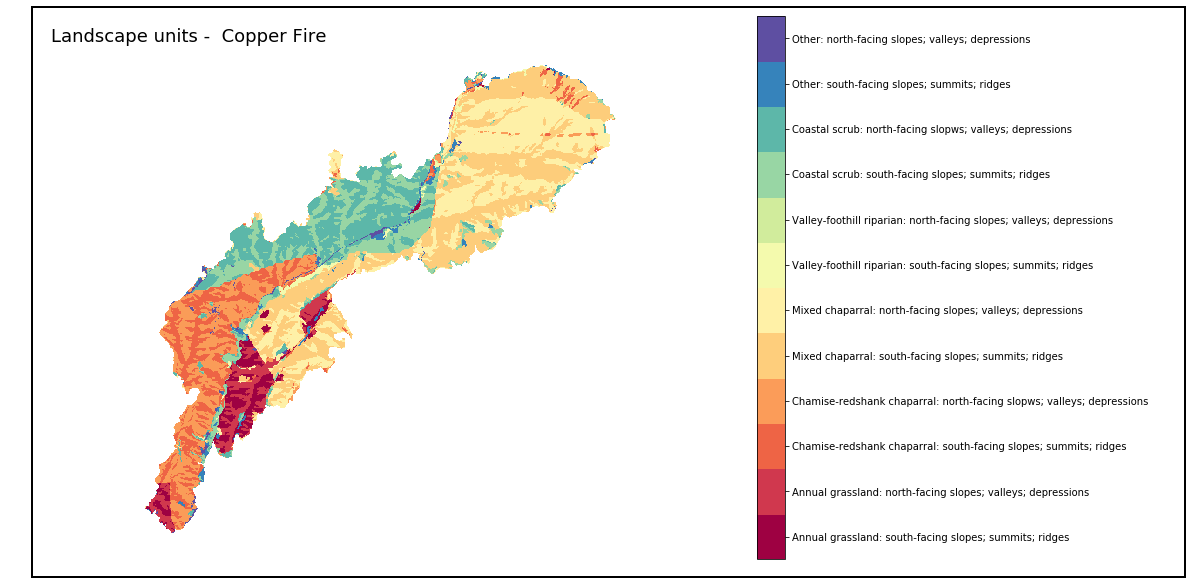

In [47]:
# Plot the vegetation x topography x aspect
if vegmapwgt.value == 'Use WHR veg types x aspect x topography':
    fvegarr = xr.open_rasterio(landscapewhrtoporast)
else:
    fvegarr = xr.open_rasterio(landscapewhrrast)    
fvegarr2 = xr.where(fvegarr == 255, np.nan, fvegarr)

fvegarr2.attrs = fvegarr.attrs # keep the geography in place
if vegmapwgt.value == 'Use WHR veg types x aspect x topography':
    veglabels = ['Annual grassland: south-facing slopes; summits; ridges', 
             'Annual grassland: north-facing slopes; valleys; depressions',
             'Chamise-redshank chaparral: south-facing slopes; summits; ridges',
             'Chamise-redshank chaparral: north-facing slopws; valleys; depressions',
             'Mixed chaparral: south-facing slopes; summits; ridges',
             'Mixed chaparral: north-facing slopes; valleys; depressions',
             'Valley-foothill riparian: south-facing slopes; summits; ridges',
             'Valley-foothill riparian: north-facing slopes; valleys; depressions',
             'Coastal scrub: south-facing slopes; summits; ridges',
             'Coastal scrub: north-facing slopws; valleys; depressions',
             'Other: south-facing slopes; summits; ridges',
             'Other: north-facing slopes; valleys; depressions']
else:
    veglabels = ['Other', #other
                'Annual grassland', # annual grassland
                'Chamise-redshank chaparral', #chamise redshank chaparral
                'Mixed chaparral', #mixed chaparral
                'Valley-foothill riparian', #valleyfoothillriparian
                'Coastal scrub'] #coastal scrub
fig, ax = plt.subplots(figsize=(18,10))
if vegmapwgt.value == 'Use WHR veg types x aspect x topography':
    cmap = plt.get_cmap('Spectral',12)
    cmap.set_over(alpha=0)
    nsgeoxWHRplot = ax.imshow(fvegarr2[0,], cmap=cmap, vmin=-0.5, vmax=11.5)
    cbar = fig.colorbar(nsgeoxWHRplot, fraction=0.03, ticks=range(12))
else:
    cmap = plt.get_cmap('Spectral',6)
    cmap.set_over(alpha=0)
    nsgeoxWHRplot = ax.imshow(fvegarr2[0,], cmap=cmap, vmin=-0.5, vmax=5.5)
    cbar = fig.colorbar(nsgeoxWHRplot, fraction=0.03, ticks=range(6))
# cmap.set_over(alpha=0)
# nsgeoxWHRplot = ax.imshow(fvegarr2[0,], cmap=cmap, vmin=-0.5, vmax=11.5)
#cbar = fig.colorbar(nsgeoxWHRplot, fraction=0.03, ticks=range(12))
cbar.ax.set_yticklabels(veglabels)
autoAxis = ax.axis()
rec = plt.Rectangle((autoAxis[0]-0.7,autoAxis[2]+20),(autoAxis[1]-autoAxis[0])+550,(autoAxis[3]-autoAxis[2])-30,fill=False,lw=2)
rec = ax.add_patch(rec)
rec.set_clip_on(False)
ax.text(20,30,"Landscape units -  Copper Fire", fontsize=18)
ax.set_axis_off();    
                   


In [48]:
fvegarr.to_netcdf('datasets/fvegarr0.nc')
#WTF? I've lost the georeferencing even here? 
# well, not exactly

In [49]:
%%html
<hr>
<h3>Select the proportion of resprouters in each class</h3>
<ul class="infobox">
    <li>This pre-populated table of the approximate proportion of resprouters has been developed based on field guides for shrublands in southern California (Gordon and White, 1994 and Borchert et al. 2004). These classes are intended as a guideline  and field surveys are strongly encouraged to confirm and/or modify these classes for the particular fire being assessed</li>
</ul>

In [50]:
# The compound widget for proportion of resprouters by veg topoclass
vglayout = widgets.Layout(width='50%', height='30px')
vgstyle ={'description_width': '300px', 'font-size': '1.1em'}
vegoptionslist = [('40-100%', 'high'), ('10-40%', 'average'), ('0-10%', 'low'), ('N/A', 'na')]
if vegmapwgt.value == 'Use WHR veg types x aspect x topography':
    vegwgt0 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='low', description='AGS: south-facing slopes; summits; ridges')
    vegwgt1 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='low', description='AGS: north-facing slopes; valleys; depressions')
    vegwgt2 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='average', description='CRC: south-facing slopes; summits; ridges')
    vegwgt3 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='average', description='CRC: north-facing slopes; valleys; depressions')
    vegwgt4 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='high', description='MCH: south-facing slopes; summits; ridges')
    vegwgt5 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='high', description='MCH: north-facing slopes; valleys; depressions')
    vegwgt6 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='na', description='VRI: south-facing slopes; summits; ridges')
    vegwgt7 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='na', description='VRI: north-facing slopes; valleys; depressions')
    vegwgt8 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='high', description='CSC: south-facing slopes; summits; ridges')
    vegwgt9 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='high', description='CSC: north-facing slopes; valleys; depressions')
    vegwgt10 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='na', description='Other: north-facing slopes; valleys; depressions')
    vegwgt11 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='na', description='Other: south-facing slopes; summits; ridges')
    vegwgtlist = [ vegwgt0, vegwgt1, vegwgt2,vegwgt3, vegwgt4, vegwgt5, vegwgt6, vegwgt7, vegwgt8, vegwgt9, vegwgt10, vegwgt11]
else:
    vegwgt0 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='low', description='Annual grassland (AGS)')
    vegwgt2 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='average', description='Chamise-redshanks chaparral (CRC)')
    vegwgt4 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='high', description='Mixed chaparral (MCH)')
    vegwgt6 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='na', description='Valley-riparian woodland (VRI)')
    vegwgt8 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='high', description='Coastal sage scrub (CSC)')
    vegwgt10 = widgets.Dropdown(options=vegoptionslist, style=vgstyle, layout=vglayout, value='na', description='Other')
    vegwgtlist = [ vegwgt0, vegwgt2,vegwgt4, vegwgt6, vegwgt8, vegwgt10]
 

vegwgtcombo = widgets.VBox(vegwgtlist)
#def resproutproportionwgt(wgtlist)
display(vegwgtcombo)


In [51]:
# We will create a dictionary in lieu for now of building a widget for the proportion of resprouters and facultative seeders
# for each veg topo class
# resproutproportion = {4 : 'high',   # Mixed chaparral: south-facing slopes; summits; ridges
#                      5: 'high',   # Mixed chaparral: north-facing slopws; valleys; depressions
#                      2 : 'average', # Chamise-redshank chaparral: south-facing slopes; summits; ridges
#                      3 : 'average', # Chamise-redshank chaparral: north-facing slopws; valleys; depressions
#                      8 : 'average', # Coastal scrub: south-facing slopes; summits; ridges
#                      9 : 'average',    # Coastal scrub: north-facing slopws; valleys; depressions
#                      6 : 'low',    # Valley-foothill riparian: south-facing slopes; summits; ridges
#                      7 : None,     # Valley-foothill riparian: north-facing slopws; valleys; depressions
#                      0 : None,     # Annual grassland: south-facing slopes; summits; ridges
#                      1 : 'low',    # Annual grassland: north-facing slopws; valleys; depressions
#                     10: 'low',    # Other: south-facing slopes; summits; ridges
#                      11: None}     # Other: north-facing slopws; valleys; depressions

def nanone(s):
    if (s == 'na'):
        return None
    else:
        return s
if vegmapwgt.value == 'Use WHR veg types x aspect x topography':
    resproutproportion = {4 : nanone(vegwgt4.value),   # Mixed chaparral: south-facing slopes; summits; ridges
                     5: nanone(vegwgt5.value),   # Mixed chaparral: north-facing slopws; valleys; depressions
                      2 : nanone(vegwgt2.value), # Chamise-redshank chaparral: south-facing slopes; summits; ridges
                      3 : nanone(vegwgt3.value), # Chamise-redshank chaparral: north-facing slopws; valleys; depressions
                      8 : nanone(vegwgt8.value), # Coastal scrub: south-facing slopes; summits; ridges
                      9 : nanone(vegwgt9.value),    # Coastal scrub: north-facing slopws; valleys; depressions
                      6 : nanone(vegwgt6.value),    # Valley-foothill riparian: south-facing slopes; summits; ridges
                      7 : nanone(vegwgt7.value),     # Valley-foothill riparian: north-facing slopws; valleys; depressions
                      0 : nanone(vegwgt0.value),     # Annual grassland: south-facing slopes; summits; ridges
                      1 : nanone(vegwgt1.value),    # Annual grassland: north-facing slopws; valleys; depressions
                     10: nanone(vegwgt10.value),    # Other: south-facing slopes; summits; ridges
                      11:nanone(vegwgt11.value)}     # Other: north-facing slopes; valleys; depressions
else:
    resproutproportion = {1 : nanone(vegwgt0.value),  
                          2: nanone(vegwgt2.value),
                          3: nanone(vegwgt4.value),
                          4: nanone(vegwgt6.value),
                          5: nanone(vegwgt8.value),
                          6: nanone(vegwgt10.value)}

def update_rp0(change):
    resproutproportion[0] = nanone(change.new)
def update_rp1(change):
    resproutproportion[1] = nanone(change.new)
def update_rp2(change):
    resproutproportion[2] = nanone(change.new)
def update_rp3(change):
    resproutproportion[3] = nanone(change.new)
def update_rp4(change):
    resproutproportion[4] = nanone(change.new)
def update_rp5(change):
    resproutproportion[5] = nanone(change.new)
def update_rp6(change):
    resproutproportion[6] = nanone(change.new)
def update_rp7(change):
    resproutproportion[7] = nanone(change.new)
def update_rp8(change):
    resproutproportion[8] = nanone(change.new)
def update_rp9(change):
    resproutproportion[9] = nanone(change.new)
def update_rp10(change):
    resproutproportion[10] = nanone(change.new)
def update_rp11(change):
    resproutproportion[11] = nanone(change.new)

if vegmapwgt.value == 'Use WHR veg types x aspect x topography':
    vegwgt0.observe(update_rp0, names='value')
    vegwgt1.observe(update_rp1, names='value')
    vegwgt2.observe(update_rp2, names='value')
    vegwgt3.observe(update_rp3, names='value')
    vegwgt4.observe(update_rp4, names='value')
    vegwgt5.observe(update_rp5, names='value')
    vegwgt6.observe(update_rp6, names='value')
    vegwgt7.observe(update_rp7, names='value')
    vegwgt8.observe(update_rp8, names='value')
    vegwgt9.observe(update_rp9, names='value')
    vegwgt10.observe(update_rp10, names='value')
    vegwgt11.observe(update_rp11, names='value')
else:
    vegwgt0.observe(update_rp0, names='value')
    vegwgt2.observe(update_rp2, names='value')
    vegwgt4.observe(update_rp4, names='value')
    vegwgt6.observe(update_rp6, names='value')
    vegwgt8.observe(update_rp8, names='value')
    vegwgt10.observe(update_rp10, names='value')


<p>Table 1. Assignment of scores based on regeneration rate determined based on the relative proportion of resprouting and facultative seeding post-fire reproductive strategies: R = resprouter species, FS = facultative seeder species</p>


![Table 1](images/Table1c.png)

Output()

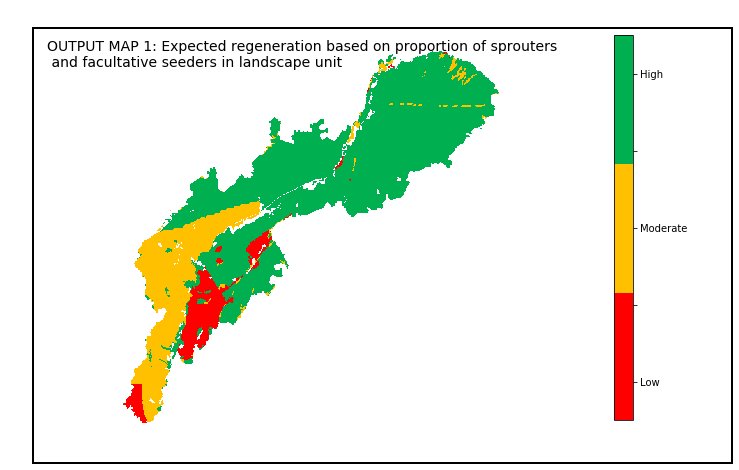

In [52]:
# Plot expected regeneration
regenrast = expregenrast(fvegarr2, selfsuccession)



# def run_current1(ev):
#    display(Javascript('IPython.notebook.execute_selected_cells()'))





outputmap1 = widgets.Output()
with outputmap1:
    fig, ax = plt.subplots(figsize=(15,8))
    cmap = redorangegreen3cm
    cmap.set_over(alpha=0)
    regenrastplot = ax.imshow(regenrast[0,], cmap=cmap, vmin=0.5, vmax=5.5)
    cbar = fig.colorbar(regenrastplot, fraction=0.023, ticks=range(1,6))
    cbar.ax.set_yticklabels(invroglabels3)
    ax.text(20, 80,"""OUTPUT MAP 1: Expected regeneration based on proportion of sprouters\n and facultative seeders in landscape unit""", fontsize=14)
    ax.set_axis_off();
    autoAxis = ax.axis()
    rec = plt.Rectangle((autoAxis[0]-0.7,autoAxis[2]+25),(autoAxis[1]-autoAxis[0])+230,(autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=2)
    rec = ax.add_patch(rec)
    rec.set_clip_on(False)

#outputmap1box = widgets.GridBox(children=[outputmap1, runcurrent1_button, downloadwgt1],
#                               layout =widgets.Layout(
#                                  grid_template_rows='auto 40px',
#                                  grid_template_columns='20% auto',
#                                  grid_template_areas='''
#                                  "outputmap1 ."
#                                  "runcurrent1_button downloadwgt1"
#                                  '''))
display(outputmap1)





In [53]:
downloadwgt1 = SaveFileButton(regenrast)
display(downloadwgt1)

SaveFileButton(description='Download output data', style=ButtonStyle(button_color='#D4D4D4'))

In [54]:
regenrast.to_netcdf('datasets/regenrastTest.nc')

In [55]:
%%html
<hr>
<h1>Step 2. Modify Regeneration Rate Based on Fire History</h1>
<h2>Task A. Specify number of fires in previous 40 years</h2>

<ul class="infobox">
    <li>Fire frequency is a key determinant on how well shrubland species recover post-fire.  </li>
    <li>Here we use a threshold of three or more fires in any given pixel in the 40 years prior to the fire date to indicate when species regeneration will be adversely effected. </li>
    <li>For running the tool on fires after 2018, this attribute appears in the FRID spatial dataset (see Technical Guide). These data need to be copied to the directory labeled 'datasets'.</li>
    </ul>


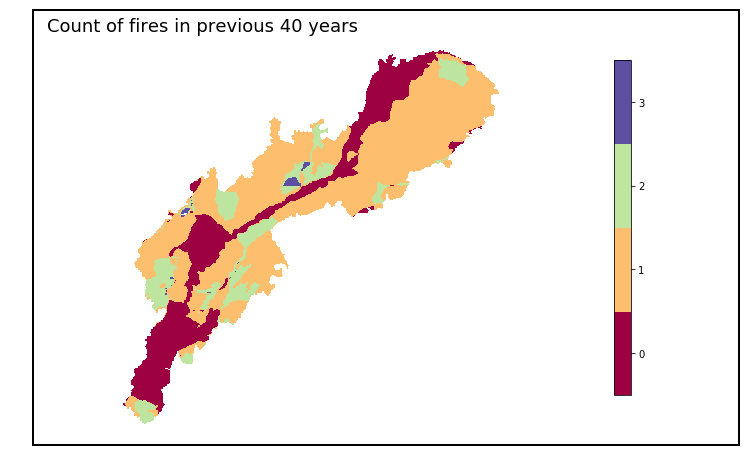

In [56]:
# plot of fire count
fcxarr = xr.open_rasterio(firecountrast)
fcxarr2 = xr.where(fcxarr == 255, np.nan, fcxarr)
fcxarr2.attrs = fcxarr.attrs
fig, ax = plt.subplots(figsize=(15,8))
cmap = plt.get_cmap('Spectral', 4)
cmap.set_over(alpha=0)
firecountplot = ax.imshow(fcxarr2[0,], cmap=cmap, vmin=-0.5, vmax=3.5)
cbar = fig.colorbar(firecountplot, fraction=0.02, ticks=range(4))

autoAxis = ax.axis()
rec = plt.Rectangle((autoAxis[0]-0.7,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+240,(autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=2)
rec = ax.add_patch(rec)
rec.set_clip_on(False)

# cbar.ax.set_yticklabels(veglabels)
# ax.set(title="Count of number of fires in previous 40 years")
ax.text(20,30, "Count of fires in previous 40 years",  fontsize=18)
ax.set_axis_off();

In [57]:
# maybe plot this as well?
tsfarr = xr.open_rasterio(timesincefirerast)
tsfarr2 = xr.where(tsfarr == 255, np.nan, tsfarr)
tsfarr2.attrs = tsfarr.attrs

<p>Table 2. Modification of regeneration rate score based on number of fires in last 40 years in each pixel</p>

![Table 2](images/Table2c.png)

In [58]:
%%html
<h2>Task B. Specify time since last fire</h2>

<ul class="infobox">
    <li>Time since last fire (TSLF) in combination with the proportion of resprouters is important to consider as many obligate seeders are particularly susceptible as they regenerate entirely from long-lived, fire-cued seed banks that require one to two decades to replenish</li>
    <li>The tool uses the TSLF attribute in the FRID dataset and uses thresholds of 0-5 years, 5-10 years, and &gt;10 years since fire </li>
    <li>Pixel scores are only modified where they have low regeneration rates, characterized by &le;10% resprouters or facultative seeders (i.e., 10-90% obligate seeders) </li>
    </ul>


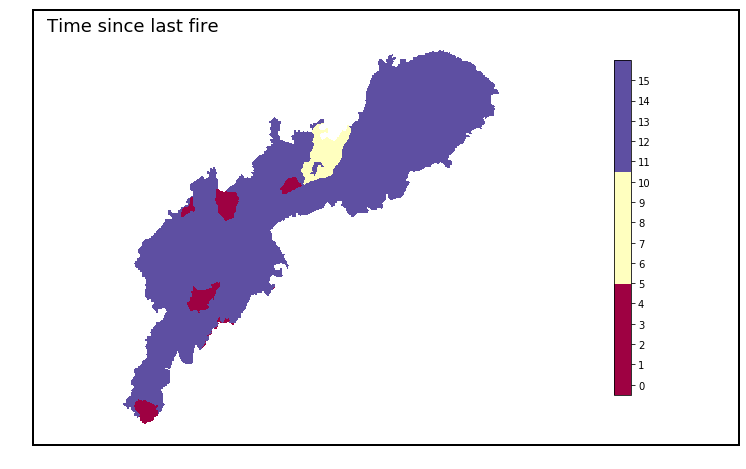

In [59]:
fig, ax = plt.subplots(figsize=(15,8))
cmap = plt.get_cmap('Spectral', 3)
cmap.set_over(alpha=0)
tsfplot = ax.imshow(tsfarr2[0,], cmap=cmap, vmin=-0.5, vmax=16)
cbar = fig.colorbar(tsfplot, fraction=0.02, ticks=range(16))

autoAxis = ax.axis()
rec = plt.Rectangle((autoAxis[0]-0.7,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+240,(autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=2)
rec = ax.add_patch(rec)
rec.set_clip_on(False)

# cbar.ax.set_yticklabels(veglabels)
# ax.set(title="Count of number of fires in previous 40 years")
ax.text(20,30, "Time since last fire",  fontsize=18)
ax.set_axis_off();

<p>Table 3. Modification of regeneration rate score based on time since last fire. This modification is only applied to pixels with low regeneration rates (&lt;10% resprouters or facultative seeders, i.e., 10-90% obligate seeders)</p>

![Table 3](images/Table3c.png)


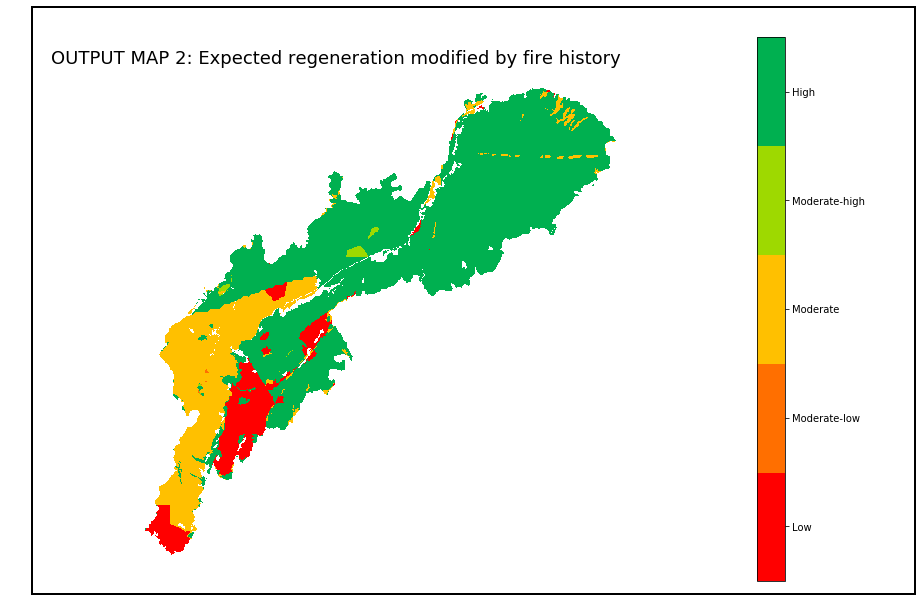

In [60]:
# plot expected regeneration modified by fire history

regenfireout = regenfirerast(regenrast, fcxarr2, tsfarr2, fvegarr2)
fig, ax = plt.subplots(figsize=(18,10))
cmap = redorangegreencm
cmap.set_over(alpha=0)
regenfireplot = ax.imshow(regenfireout[0,], cmap=cmap, vmin=0.5, vmax=5.5)
cbar = fig.colorbar(regenfireplot, fraction=0.03, ticks=range(1,6))
cbar.ax.set_yticklabels(invroglabels)
autoAxis = ax.axis()
rec = plt.Rectangle((autoAxis[0]-0.7,autoAxis[2]+ 15),(autoAxis[1]-autoAxis[0])+240,(autoAxis[3]-autoAxis[2])-50,fill=False,lw=2)
rec = ax.add_patch(rec)
rec.set_clip_on(False)
ax.text(20,30, "OUTPUT MAP 2: Expected regeneration modified by fire history", fontsize=18)

#ax.set(title="OUTPUT MAP 2: Expected regeneration modified by fire history")
ax.set_axis_off();



In [61]:
# download output data
downloadwgt2 = SaveFileButton(regenfireout)
display(downloadwgt2)

SaveFileButton(description='Download output data', style=ButtonStyle(button_color='#D4D4D4'))

*********
# Step 3. Modify Regeneration Rate Based on Drought



In [62]:
# drought modification widget
drS1 ={'description_width': '250px'}
#drstyle2 = widgets.widget_description.DescriptionStyle(value='font-size:1em; font-weight:bold;')
drS2 = 'style="font-size: 1.5em; font-weight: bold"'
drS3 = 'style="font-style: italic; color: #4057A9; font-size: 1.1em; line-height: 100%"'
drS4 = 'style="font-size: 1.2em; font-weight: normal; line-height: 100%"'
drS5 ={'description_width': '250px'}
drS6 ={'description_width': '200px'}
drS7 = 'style="color: blue; font-size: 1.3em; line-height: 110%"; '





#droughtwgt_t1 = widgets.HTML(value='Step 1a. Specify drought or non-drought conditions pre-fire', style=drstyle2)
droughtwgt_t1 = widgets.HTML(value=f"<div {drS2}> Task A. Specify drought or non-drought conditions pre-fire</div>")
droughtwgt_t2 = widgets.HTML(value=f"<div {drS7}><ul><li>Drought conditions pre-fire can affect the regeneration capacity of sprouting species post-fire.</li><li>Here we link to data for the South Coast Ecoregion on the Palmer Drought Severity Index and determine how many months out of the 12 months prior to the start of the fire were &lsquo;severe&rsquo; or &lsquo;extreme&rsquo; drought </li></ul></div>")
droughtwgt_t3 = widgets.HTML(value=f"<div {drS4}>Link to: <a href='https://www.ncdc.noaa.gov/temp-and-precip/drought/historical-palmers'>NOAA Palmer Drought Severity Index</a> website and enter the &lsquo;start year&rsquo; and &lsquo;start month&rsquo; (12 months before the fire start date) and the &lsquo;end year&rsquo; and &lsquo;end month&rsquo;.  Record the number of months that the South Coast ecoregion is shown as &lsquo;moderate&rsquo; (&lt;-3PDSI )or &lsquo;extreme&rsquo; (&lt;-4 PDSI)</div>")
droughtwgt_e1 = widgets.BoundedIntText(
    value=3,
    min=0,
    max=12,
    step=1,
    description='Number of months in previous 12 months with severe or extreme PDSI ',
    disabled=False,
    style=drS1
)
# droughtwgt_t35 = widgets.HTML(value=f"<div {drS4}><table><tr><td></td><td colspan=2><strong>&ge;6 months drought</strong></td></tr><tr><td></td><td>moderate</td><td>severe or extreme</td></tr><tr><td><strong>Year prefire</strong></td><td>no change</td><td>reduce by one class</td></tr></table></div>")


droughtwgt_b1 = widgets.GridBox(children=[droughtwgt_t1, droughtwgt_t2, droughtwgt_t3, droughtwgt_e1] ,
                                layout=widgets.Layout(
                                    grid_template_rows='auto auto auto auto',
                                    grid_template_columns='100%',
                                    grid_gap='20px 10px'))
display(droughtwgt_b1)
prefiredrought = False

def update_droughtwgt_e1(change):
    global prefiredrought
    if change.new < 3:
        prefiredrought = False
    else:
        prefiredrought = True
        
        

        
        
   
droughtwgt_e1.observe(update_droughtwgt_e1, names='value')



    


GridBox(children=(HTML(value='<div style="font-size: 1.5em; font-weight: bold"> Task A. Specify drought or non…

<p>Table 4. Modification of regeneration rate score in pixels with &ge; 40% resprouter or facultative seeders, based on occurrence of severe or extreme drought in four of the seven months of the growing season (November to May) before the fire</p>

![Table 4](images/Table4c.png)

In [63]:
droughtwgt_t4 = widgets.HTML(value=f"<div {drS2}> Task B. Specify drought or non-drought conditions post-fire</div>")
droughtwgt_t5 = widgets.HTML(value=f"<div {drS7}><ul><li>Drought conditions post-fire can affect the ability of seeds to germinate and also the survival of seedlings, so it is critical consideration for the recovery of seeder species</li><li>Again, we link to data for the South Coast Ecoregion on the Palmer Drought Severity Index and determine how many months out of the 12 months after the start of the fire were &lsquo;severe&rsquo; or &lsquo;extreme&rsquo; drought </li><li>The tool is able to consider drought conditions for up to 3 years post-fire, but the tool can still be run if there are only data on year 1 and 2 post-fire</li></ul></div>")
droughtwgt_t6 = widgets.HTML(value=f"<div {drS4}>Link to: <a href='https://www.ncdc.noaa.gov/temp-and-precip/drought/historical-palmers'>NOAA Palmer Drought Severity Index</a> website and enter the &lsquo;start year&rsquo; and &lsquo;start month&rsquo; (12 months before the fire start date) and the &lsquo;end year&rsquo; and &lsquo;end month&rsquo;.  Record the number of months that the South Coast ecoregion is shown as &lsquo;moderate&rsquo; (&lt;-3PDSI )or &lsquo;extreme&rsquo; (&lt;-4 PDSI)</div>")
droughtwgt_t7 = widgets.HTML(value=f"<div {drS2}> Task C.  Specify if fire occurs in wet season or dry season</div>")

droughtwgt_e2 = widgets.BoundedIntText(
    value=3,
    min=0,
    max=12,
    step=1,
    description='Post-fire year 1: Number of months',
    disabled=False,
    style=drS5)
droughtwgt_e3 = widgets.BoundedIntText(
    value=1,
    min=0,
    max=12,
    step=1,
    description='Post-fire year 2: Number of months',
    disabled=False,
    style=drS5)
droughtwgt_e4 = widgets.BoundedIntText(
    value=0,
    min=0,
    max=12,
    step=1,
    description='Post-fire year 3: Number of months',
    disabled=False,
    style=drS5)

# droughtwgt_options = ['None', 'Moderate', 'Severe', 'Extreme']
# droughtwgt_e2 = widgets.Dropdown(
#    options=droughtwgt_options,
#    value='Moderate',
#    description='Post-fire year 1: Drought status >=6 months',
#    disabled=False,
#    style=drS6)
# droughtwgt_e3 = widgets.Dropdown(
#    options=droughtwgt_options,
#    value='Moderate',
#    description='Post-fire year 2: Drought status >=6 months',
#    disabled=False,
 #   style=drS6)
# droughtwgt_e4 = widgets.Dropdown(
#    options=droughtwgt_options,
#    value='Moderate',
#    description='Post-fire year 3: Drought status >=6 months',
#    disabled=False,
 #   style=drS6)

droughtwgt_e5 = widgets.BoundedIntText(
    value=3,
    min=1,
    max=3,
    step=1,
    description='No. of years post-fire drought data is available',
    style=drS6
    )

droughtwgt_e6 = widgets.RadioButtons(
    options=['Dry season fire (May-Oct)', 'Wet season fire (Nov-Apr)'],
    description='Season of fire',
    value='Dry season fire (May-Oct)',
    disabled=False)

droughtwgt_b2 = widgets.GridBox(children=[droughtwgt_t4, droughtwgt_t5, droughtwgt_t6,
                                          droughtwgt_e5, droughtwgt_e2, droughtwgt_e3, droughtwgt_e4, droughtwgt_t7, droughtwgt_e6],
                                layout=widgets.Layout(
                                    grid_template_rows='auto auto auto auto auto auto auto auto auto auto',
                                    grid_template_columns='100%',
                                    grid_gap='20px 10px'))
display(droughtwgt_b2)

numpostfireyears = 3
        
def update_droughtwgt_e5(change):
    global numpostfireyears
    if change.new == 3:
        droughtwgt_e4.layout.display = 'initial'
        droughtwgt_e3.layout.display = 'initial'
        droughtwgt_e2.layout.display = 'initial'
        numpostfireyears = 3
    elif change.new == 2:
        droughtwgt_e4.layout.display = 'none'
        droughtwgt_e3.layout.display = 'initial'
        droughtwgt_e2.layout.display = 'initial'
        numpostfireyears = 2
    elif change.new == 1:
        droughtwgt_e4.layout.display = 'none'
        droughtwgt_e3.layout.display = 'none'
        droughtwgt_e2.layout.display = 'initial'
        numpostfireyears = 1
        
          

droughtwgt_e5.observe(update_droughtwgt_e5, names='value')

postyear1drought = False
postyear2drought = False
postyear3drought = False
fireseason = 'dry'

def update_droughtwgt_e6(change):
    global fireseason
    if change.new == 'Dry season fire (May-Oct)':
        fireseason = 'dry'
    else:
        fireseason = 'wet'        
   
droughtwgt_e6.observe(update_droughtwgt_e6, names='value')


def update_droughtwgt_e2(change):
    global postyear1drought
    if change.new < 4:
        postyear1drought = False
    else:
        postyear1drought = True        
   
droughtwgt_e2.observe(update_droughtwgt_e2, names='value')
    
def update_droughtwgt_e3(change):
    global postyear2drought
    if change.new < 4:
        postyear2drought = False
    else:
        postyear2drought = True
        
droughtwgt_e3.observe(update_droughtwgt_e3, names='value')
   
def update_droughtwgt_e4(change):
    global postyear3drought
    if change.new < 4:
        postyear3drought = False
    else:
        postyear3drought = True        
   
droughtwgt_e4.observe(update_droughtwgt_e4, names='value')

GridBox(children=(HTML(value='<div style="font-size: 1.5em; font-weight: bold"> Task B. Specify drought or non…

<p>Table 5. Modification of regeneration rate score in pixels with (a) ≥ 40% resprouter or facultative seeders and (b) 10-40% and &lt; 10% resprouter or facultative seeders based on occurrence of severe or extreme drought in ≥ 4 of the growing season months (November to May) in years 1 to 3 post-fire </p> 

![Table 5](images/Table5c.png)

<p> Table 6. Modification of regeneration rate score in pixels with 10-40% and &lt;10% resprouter or facultative seeders, based on occurrence of fire in the dry season</p>

![Table 6](images/Table6c.png)



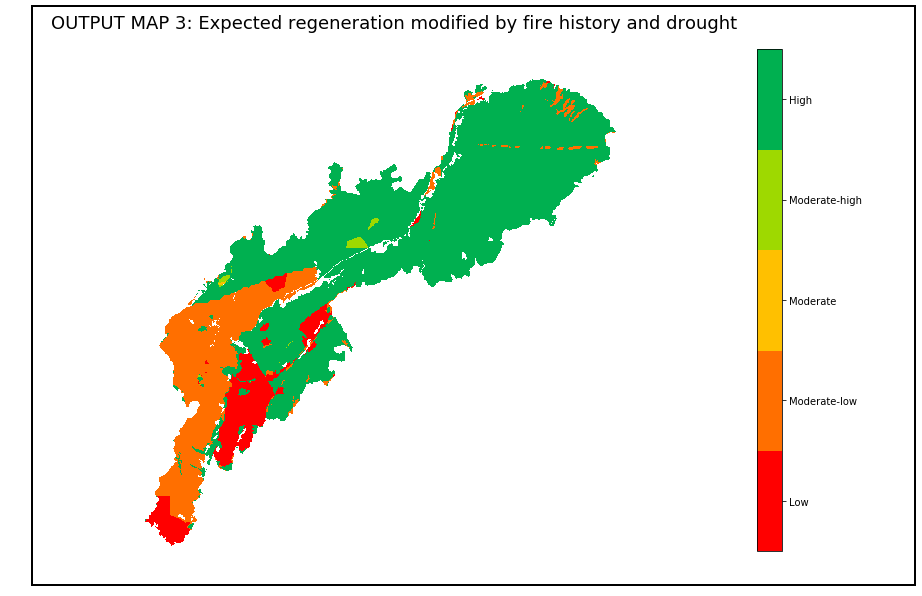

In [64]:
# plot expected regeneration with fire modified by drought
# droughtmr = droughtmodifyrast(regenfireout, fvegarr2, prefiredrought, (False, False, False, False) )
droughtmr = droughtmodifyrast2(regenfireout, fvegarr2, prefiredrought, postyear1drought, postyear2drought, postyear3drought, fireseason, numpostfireyears)

fig, ax = plt.subplots(figsize=(18,10))
cmap = redorangegreencm
cmap.set_over(alpha=0)
droughtmrplot = ax.imshow(droughtmr[0,], cmap=cmap, vmin=0.5, vmax=5.5)
cbar = fig.colorbar(droughtmrplot, fraction=0.025, ticks=range(1,6))
cbar.ax.set_yticklabels(invroglabels)
# ax.set(title="OUTPUT MAP 3: Expected regeneration modified by fire history and drought")
autoAxis = ax.axis()
rec = plt.Rectangle((autoAxis[0]-0.7,autoAxis[2]+15),(autoAxis[1]-autoAxis[0])+240,(autoAxis[3]-autoAxis[2])-40,fill=False,lw=2)
rec = ax.add_patch(rec)
rec.set_clip_on(False)
ax.text(20,0, "OUTPUT MAP 3: Expected regeneration modified by fire history and drought",  fontsize=18)
ax.set_axis_off();

In [65]:
# download output data
downloadwgt3 = SaveFileButton(droughtmr)
display(downloadwgt3)

SaveFileButton(description='Download output data', style=ButtonStyle(button_color='#D4D4D4'))

In [66]:
%%html

<h1>Step 4. Modify Regeneration Rate Based on Non-Native Grasses</h1>
<h2>Specify abundance on non-native grasses</h2>

<ul class="infobox">
    <li >The presence of non-native grasses effects the ability of seeding species to germinate and survive post-fire.</li>
    <li>Here we upload spatial data on the percent herbaceous cover <strong>pre-fire</strong> derived from Landsat imagery (Park et al. 2018) which has been correlated to be non-native species.</li>
    <li>The threshold of % herbaceous cover is defined by the user. As a guide, a conservative threshold of 20% is used as the default: above this threshold then non-native species are considered a high risk to the maintenance of desired conditions.</li>
 </ul>   



In [67]:
# threshold widget
nnS1 ={'description_width': '200px'}
nnwgt_e1 = widgets.BoundedIntText(
    value=20,
    min=0,
    max=100,
    step=10,
    description='Enter % threshold of herbaceous cover',
    disabled=False,
    style=nnS1
)
display(nnwgt_e1)

# initial threshold and invasives dictionary
invasivethreshold = 0.2

def update_nnwgt_e1(change):
    global invasivethreshold
    invasivethreshold = change.new * 0.01
    # print(invasivethreshold)
    
nnwgt_e1.observe(update_nnwgt_e1, names='value')

    
# invasivethreshold = 0.3

# tuples are (amount of resprouters, herbaceous cover)
invasivedict = {('high', 'high'): 0,
                ('high', 'low'): 0,
                ('average', 'high'): -1,
                ('average', 'low'): 0,
                ('low', 'high'): -1,
                ('low', 'low'): 0,
                (None, 'high'): np.nan,
                (None, 'low'): np.nan,
                ('high', None): np.nan,
                ('average', None): np.nan,
                ('low', None): np.nan}

BoundedIntText(value=20, description='Enter % threshold of herbaceous cover', step=10, style=DescriptionStyle(…

<p>Table 7. Modification of regeneration rate score based on % cover of non-native grasses in each pixel</p>

![Table 7](images/Table7c.png)

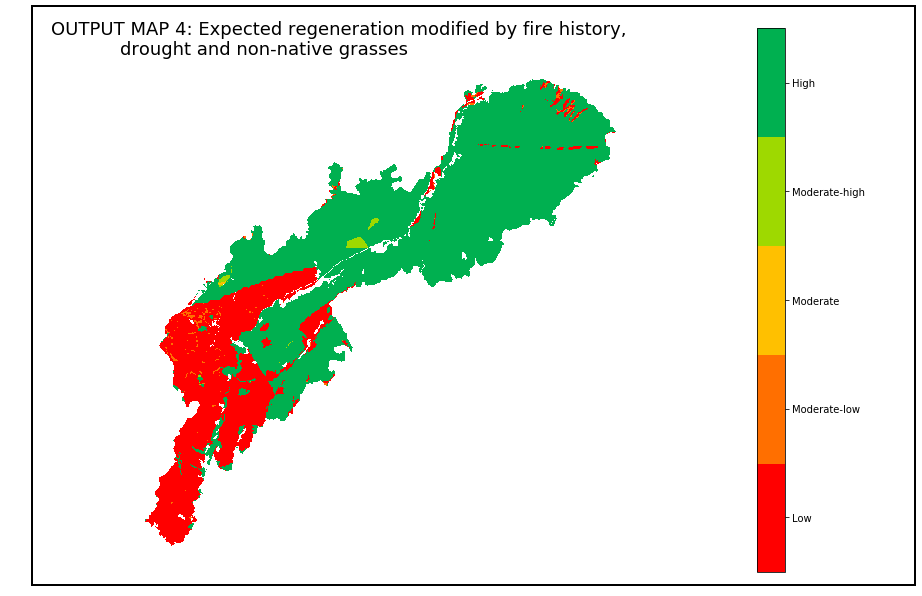

In [68]:
# plot expected regeneration with fire modified by drought and invasives
herbrast = xr.open_rasterio(nonnativerast)
invasivemr = invasivesmodifyrast(droughtmr, fvegarr2, herbrast, invasivethreshold)


fig, ax = plt.subplots(figsize=(18,10))
cmap = redorangegreencm
cmap.set_over(alpha=0)
invasivemrplot = ax.imshow(invasivemr[0,], cmap=cmap, vmin=0.5, vmax=5.5)
cbar = fig.colorbar(invasivemrplot, fraction=0.03, ticks=range(1,6))
cbar.ax.set_yticklabels(invroglabels)
#ax.set(title="OUTPUT MAP 4: Expected regeneration modified by fire history, drought and non-native grasses")
autoAxis = ax.axis()
rec = plt.Rectangle((autoAxis[0]-0.7,autoAxis[2]+15),(autoAxis[1]-autoAxis[0])+240,(autoAxis[3]-autoAxis[2])-40,fill=False,lw=2)
rec = ax.add_patch(rec)
rec.set_clip_on(False)
ax.text(20,30, """OUTPUT MAP 4: Expected regeneration modified by fire history, 
            drought and non-native grasses""",  fontsize=18)
ax.set_axis_off();

In [69]:
# download output data
downloadwgt4 =  SaveFileButton(invasivemr)
display(downloadwgt4)

SaveFileButton(description='Download output data', style=ButtonStyle(button_color='#D4D4D4'))

In [70]:
%%html
<hr>
<h1>Step 5. Integrate Erosion Risk</h1>
<ul>
<li class="infotext">The loss of vegetation cover post-fire increases the risk of erosion</li>
<li class="infotext">Here we integrate erosion risk data from USDA Forest Service BAER (Burned Area Emergency Response) which is 
modeled immediately post-fire using the USFS ERMIT tool (based on WEPP)</li>
<li class="infotext">The erosion rate (tons/ha) are relative to an unburned landscape and associated (in this case) with a one in five year erosion event.</li>
</ul>

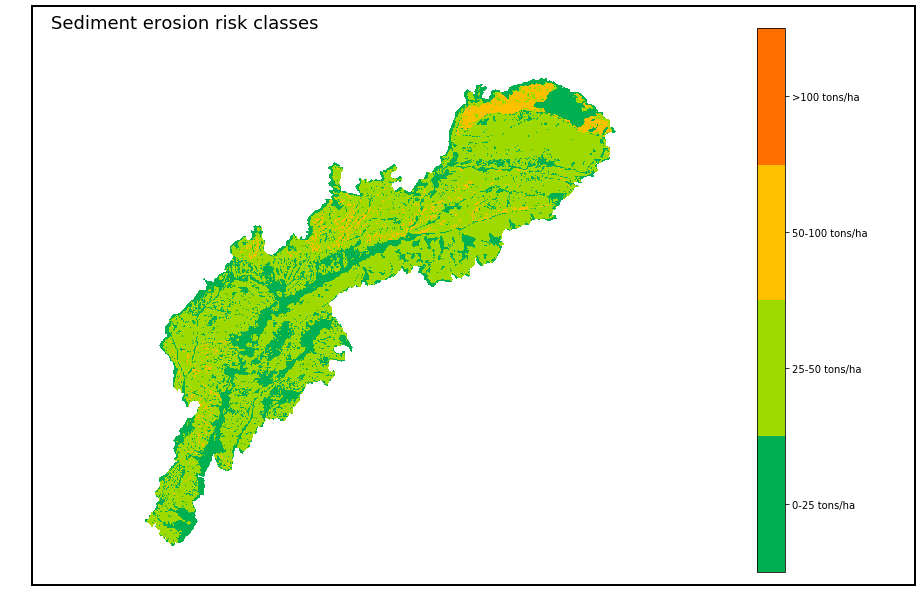

In [71]:
# plot erosion classes

erosionarr = xr.open_rasterio(erosionrast)
erosioncrast = erosionclassrast(erosionarr)
fig, ax = plt.subplots(figsize=(18,10))
cmap = greenorangeredcm4
cmap.set_over(alpha=0)
erosionplot = ax.imshow(erosioncrast[0,], cmap=cmap, vmin=0.5, vmax=4.5)
cbar = fig.colorbar(erosionplot, fraction=0.03, ticks=range(1,5))
erosionclasslabels = ['0-25 tons/ha', '25-50 tons/ha', '50-100 tons/ha', '>100 tons/ha']
cbar.ax.set_yticklabels(erosionclasslabels)
# ax.set(title="autoAxis = ax.axis()
autoAxis = ax.axis()
rec = plt.Rectangle((autoAxis[0]-0.7,autoAxis[2]+15),(autoAxis[1]-autoAxis[0])+240,(autoAxis[3]-autoAxis[2])-40,fill=False,lw=2)
rec = ax.add_patch(rec)
rec.set_clip_on(False)
ax.text(20,0, "Sediment erosion risk classes", fontsize=18)
ax.set_axis_off();

In [72]:
%%html

<ul class="infotext">
<li>The integration of data on (modified) regeneration capacity and erosion risk allows the identification of areas within the fire perimeter that are potentially the most vulnerable to fire, i.e., areas with lower regeneration capacity and with more risk of soil erosion </li>
<li>We recommend a field survey is carried out 2-3 years post-fire to assess the impacts of fire history, 
drought, and non-native grasses on the predicted regeneration rate. on regeneration rate map and to improve the assessment of impacts from drought and non-native grasses. </li>
</ul>




<p>Table 8. Integration of the regeneration rate (based on post-fire reproductive strategy, fire history, pre- and post-fire drought, and non-native grass cover) and the BAER erosion risk data</p>

![Table 8](images/Table8c.png)

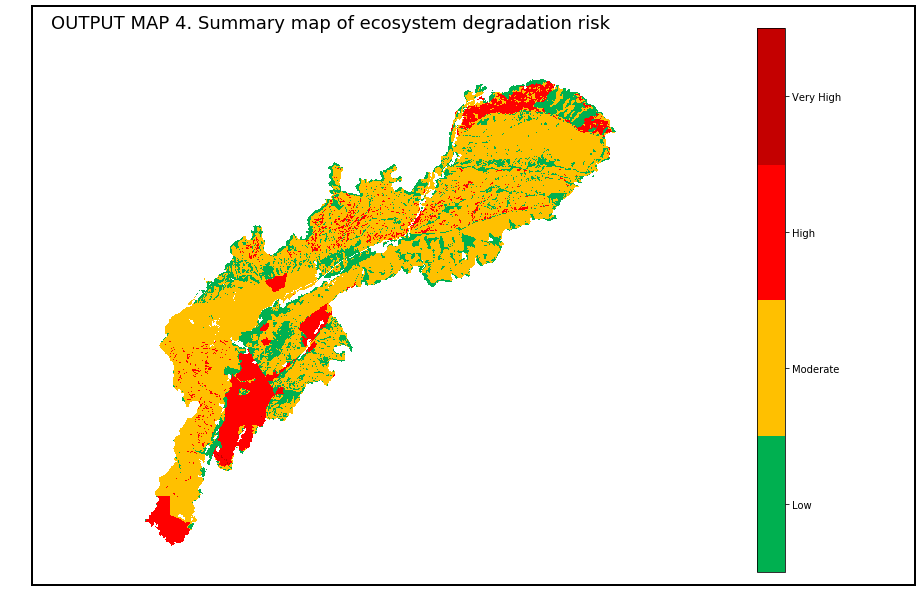

In [73]:
# plot erosion by vulnerability
erosionvrast = erosionvulnrast(droughtmr, erosioncrast)

fig, ax = plt.subplots(figsize=(18,10))
cmap = veryredorangegreencm
cmap.set_over(alpha=0)
erosionvplot = ax.imshow(erosionvrast[0,], cmap=cmap, vmin=0.5, vmax=4.5)
cbar = fig.colorbar(erosionvplot, fraction=0.03, ticks=range(1,5))
erosionvulnlabels = ['Low', 'Moderate', 'High', 'Very High']
cbar.ax.set_yticklabels(erosionvulnlabels)
# ax.set(title="Final vulnerability map")
autoAxis = ax.axis()
rec = plt.Rectangle((autoAxis[0]-0.7,autoAxis[2]+15),(autoAxis[1]-autoAxis[0])+240,(autoAxis[3]-autoAxis[2])-40,fill=False,lw=2)
rec = ax.add_patch(rec)
rec.set_clip_on(False)
ax.text(20,0, "OUTPUT MAP 4. Summary map of ecosystem degradation risk",  fontsize=18)
ax.set_axis_off();

In [74]:
# download output data
downloadwgt5 =  SaveFileButton(erosionvrast)
display(downloadwgt5)

SaveFileButton(description='Download output data', style=ButtonStyle(button_color='#D4D4D4'))